In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import os
import datetime

2022-09-25 18:58:07.699035: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-25 18:58:07.703147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-25 18:58:07.703159: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


> En este *notebook* se agregan los datos para obtener una observación cada 5 minutos. Luego se analiza la serie temporal. Finalmente se entrena un modelo LSTM *multi-step single-shot* y se evalúa su rendimiento.

### Importa el dataset

In [2]:
df = pd.read_csv("ts_tv08.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")

### Visualiza el dataset

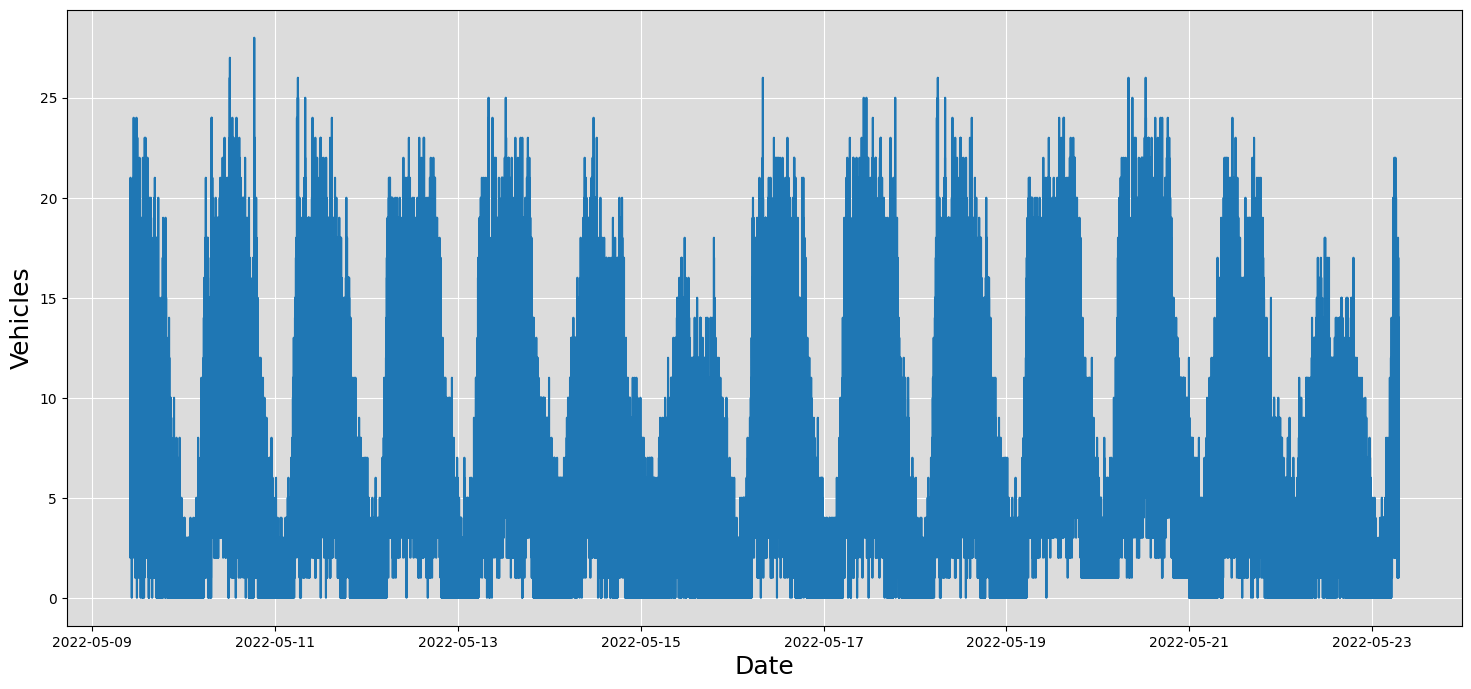

In [3]:
fig, axis = plt.subplots(facecolor="white", figsize=(18, 8))

axis.set_xlabel(xlabel="Date", fontsize=18)
axis.set_ylabel(ylabel="Vehicles", fontsize=18)    
axis.grid(color="white")
axis.set_facecolor("gainsboro")
axis.plot(df["n_vehicles"])

### Agrego los datos cada 5 minutos usando la mediana

In [4]:
df = df.resample("5T").median().ffill().astype(int)

### Describe algunos valores estadísticos

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_vehicles,3996.0,5.800801,3.950363,0.0,2.0,6.0,9.0,17.0


### Divide los datos en los conjuntos: `train`, `validation` y `test`

> Los datos no se mezclan a la hora de hacer la división. Se necesitan los datos de forma consecutiva.

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
 
train_df = df[0:int(n*0.7)] 
val_df = df[int(n*0.7):int(n*0.9)] 
test_df = df[int(n*0.9):]

num_features = df.shape[1]

> Es muy importante normalizar los datos.

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Comprueba que la serie es estacionaria

In [8]:
from statsmodels.tsa.stattools import adfuller


def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags','# of observations used']
    
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis.\nReject Null Hypothesis.\nData has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis.\nFail to reject Null Hypothesis.\nData has a unit root and is non-stationary.")

adf_check(df['n_vehicles'][:10000])

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.210959378281832
p-value : 8.350248818496517e-06
# of lags : 28
# of observations used : 3967
Strong evidence against null hypothesis.
Reject Null Hypothesis.
Data has no unit root and is stationary.


### Clase Data Window

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


### Split Window

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Visualización

In [11]:
def plot(self, model=None, plot_col="n_vehicles", max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### Dataset de `TensorFlow`

In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Pronóstico de series temporales *multi-step* directo

Predecir las 24 horas siguientes dada la semana anterior.

2022-09-25 18:58:11.705253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-25 18:58:11.705277: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-25 18:58:11.705302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Desarrollo14): /proc/driver/nvidia/version does not exist
2022-09-25 18:58:11.705561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total window size: 792
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

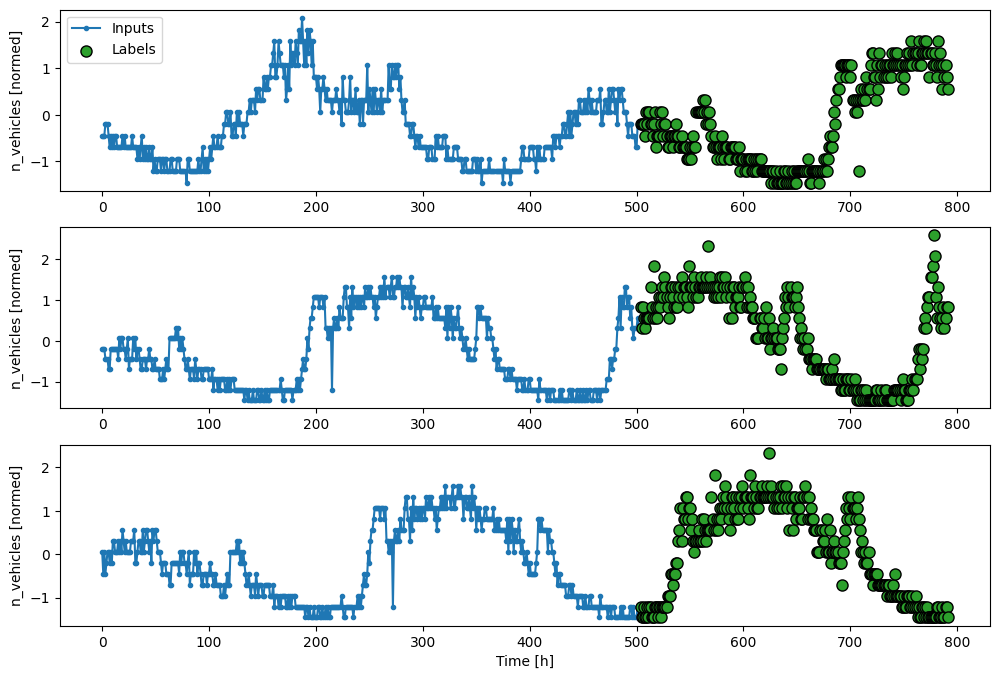

In [13]:
OUT_STEPS = 288 # (24*60)/5 = 288 puntos para representar 24 horas en grupos de 5 minutos
multi_window = WindowGenerator(input_width=504, # 1,75 días
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Proceso de entrenamiento

In [14]:
multi_val_performance = {}
multi_performance = {}

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

1/1 [==============================] - 0s 52ms/step - loss: 0.1072 - mean_absolute_error: 0.2602


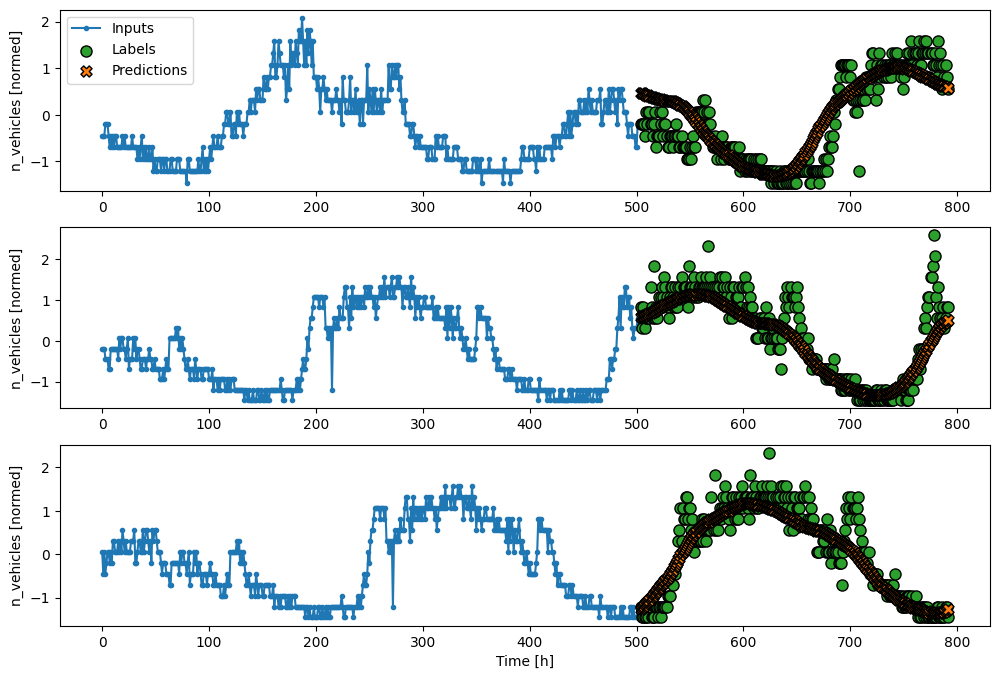

In [17]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)